# Transfer Learning with TensorFlow part 2: Fine Tuning

It's time to learn about a new kind of transfer learning: fine-tuning

## Creating helper functions

In the previous notebook, we've created a bunch of helper functino, we could re-write them all but this is tedious.

So, it's a good idea to put functions we'll want to use again in a script we can download and import into our notebooks (or elsewhere).

We've done this for some of the functnios we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-19 08:43:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-19 08:43:20 (73.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import helper funions we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If we're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so we'll have to redownload it if we want access to our helper functions.

## Let's get some data


This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recoginizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
# Get 10% of traning of 10 classes of 10 food

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-02-19 08:43:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 142.250.73.240, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  69.4MB/s    in 2.3s    

2022-02-19 08:43:25 (69.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Check out how many images and subdirectories are in our dataset

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [5]:
# Create traning and test directory paths

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [6]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the class names of our dataset

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data

for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[ 14.642858    20.642857    20.642857  ]
   [ 15.928572    21.928572    21.928572  ]
   [ 16.          22.          22.        ]
   ...
   [  6.785736    10.785736    11.785736  ]
   [  6.311216    10.311216    11.168333  ]
   [  3.7142508    7.714251     6.714251  ]]

  [[ 14.          20.          20.        ]
   [ 15.862246    21.862246    21.862246  ]
   [ 15.729591    21.729591    21.729591  ]
   ...
   [  5.4439197    9.443919    10.443919  ]
   [  6.9949102   10.99491     11.852027  ]
   [  6.903059    10.903059     9.903059  ]]

  [[ 14.          20.          20.        ]
   [ 15.          21.          21.        ]
   [ 15.          21.          21.        ]
   ...
   [  4.57145      8.57145      9.57145   ]
   [  5.214286     9.214286    10.071403  ]
   [  4.352033     8.352034     7.352033  ]]

  ...

  [[125.153145   119.93885     98.795975  ]
   [115.12763    108.96945     92.35719   ]
   [129.70935    124.32669    105.02056   ]
   ...
   [119.550964   133.045

## Model 0: Building a transfer learning feature extraction model using the Keras Functinoal API 

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models  - https://www.tensorflow.org/guide/keras/functional

In [10]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2. Freeze the base model ( so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using a model like ResNet50V2 we will need to normalize inputs (we don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation = "softmax", name = "ouput_layer")(x)

# 8. Combine the inputs with the ouputs into a model
model_0  = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model 
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25*len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name = "10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220219-084338
Epoch 1/5
24/24 [==============================] - 20s 217ms/step - loss: 1.8956 - accuracy: 0.3933 - val_loss: 1.3768 - val_accuracy: 0.6776
Epoch 2/5
24/24 [==============================] - 4s 152ms/step - loss: 1.1482 - accuracy: 0.7173 - val_loss: 0.9341 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.8430 - accuracy: 0.7987 - val_loss: 0.7866 - val_accuracy: 0.8059
Epoch 4/5
24/24 [==============================] - 5s 180ms/step - loss: 0.6937 - accuracy: 0.8293 - val_loss: 0.6875 - val_accuracy: 0.8224
Epoch 5/5
24/24 [==============================] - 5s 204ms/step - loss: 0.5999 - accuracy: 0.8533 - val_loss: 0.6333 - val_accuracy: 0.8273


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.6175 - accuracy: 0.8328


[0.6174768805503845, 0.8327999711036682]

In [12]:
# Check the layers in our base model

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [14]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


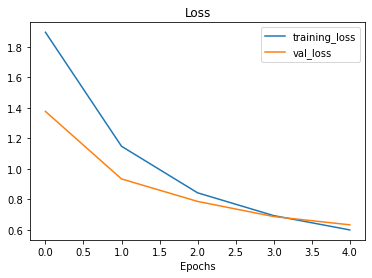

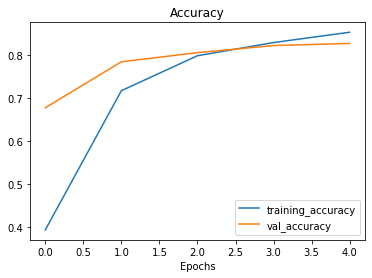

In [15]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Demonstarte the Gloabal Average Pooling 2D layer...

WE have a tensor after our model goes through `base_model` of shape (None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.


In [16]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensro
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor :\n {global_average_pooled_tensor}\n")

# check the shape of the differnet tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor :
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [17]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

>**Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D` ... and see what happens

> **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a feature vector ( a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.kears.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... How about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learniong with 1% of the training data with data augmentation

2. `model_2` - use feature extraction transfer learning with 10% of thte training with data augmenation

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [19]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-02-19 08:45:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 142.250.188.208, 142.251.33.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  65.4MB/s    in 1.9s    

2022-02-19 08:45:13 (65.4 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"



In [21]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [22]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into model

To Add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`


We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation


Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather tan the CPU

* Image data augmenation only happens during training, so we can still export our whole model and use it elsewhere.

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## Visualize data augmentation layer (and see what happens to data)

(-0.5, 511.5, 246.5, -0.5)

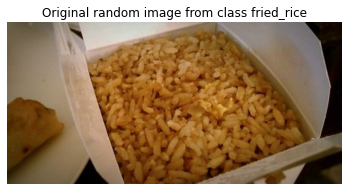

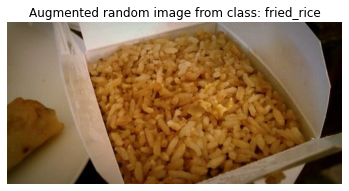

In [28]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image


# Read in the random image
img = mpimg.imread(random_image_path)
# print(target_dir)
# print(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

# plt.imshow(tf.squeeze(augmented_img)) /// Clipping input data to the valid range for imshow Error!!

In [29]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (247, 512, 3)             0         
                                                                 
 random_rotation (RandomRota  (247, 512, 3)            0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (247, 512, 3)             0         
                                                                 
 random_height (RandomHeight  (247, 512, 3)            0         
 )                                                               
                                                                 
 random_width (RandomWidth)  (247, 512, 3)             0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable

## Model 1:Feature extraction transfer learning on 1% of the data withb

In [30]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220219-084716
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.3539 - accuracy: 0.1000 - val_loss: 2.2084 - val_accuracy: 0.1990
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1298 - accuracy: 0.3000 - val_loss: 2.0826 - val_accuracy: 0.3224
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9494 - accuracy: 0.4429 - val_loss: 1.9867 - val_accuracy: 0.4013
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8115 - accuracy: 0.5571 - val_loss: 1.8780 - val_accuracy: 0.4523
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6575 - accuracy: 0.6429 - val_loss: 1.8163 - val_accuracy: 0.4671


In [31]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 93ms/step - loss: 1.8286 - accuracy: 0.4644


[1.828614592552185, 0.4643999934196472]

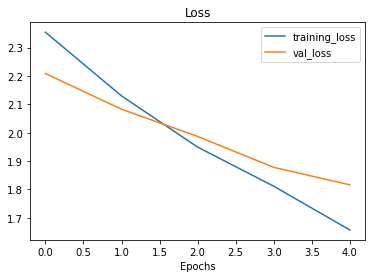

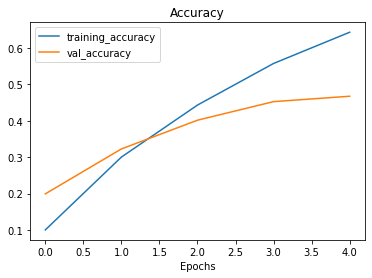

In [32]:
# How do the model with 1% of the data and data augmenation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [33]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"



In [34]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = "categorical",
                                                               image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [38]:
# Create model 2 with data augmentation built in
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2),

],name = "data_augmentation")

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape = input_shape,name = "input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation does not occur on test data)
x = base_model(x,training = False) # pass augmented images to base model but keep it in inference model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = layers.Dense(10,activation = "softmax",name = "output_layer")(x)
model_2 = tf.keras.Model(inputs,outputs)

# compile
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])




In [40]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [41]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a ModelCheckpoint Callback


The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off

In [47]:
# SEt checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq= "epoch", # save every epoch
                                                         verbose = 1) 

### Fit model 2 passing in the ModelCheckpoint callback

In [50]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25*len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                   experiment_name = "10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220219-090109
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9569 - accuracy: 0.3800
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 459ms/step - loss: 1.9569 - accuracy: 0.3800 - val_loss: 1.4662 - val_accuracy: 0.6908
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3381 - accuracy: 0.6947
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 417ms/step - loss: 1.3381 - accuracy: 0.6947 - val_loss: 1.0753 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0283 - accuracy: 0.7720
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 431ms/step - loss: 1.0283 - accuracy: 0.7720 - val_loss: 0.8829 - val_accuracy: 0.7878
E

In [51]:
# Model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 8s 84ms/step - loss: 0.6175 - accuracy: 0.8328


[0.6174769401550293, 0.8327999711036682]

In [53]:
# Check model_2  results on all test_dta
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6894 - accuracy: 0.8200


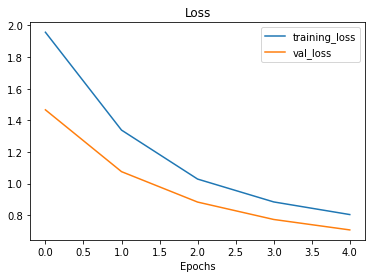

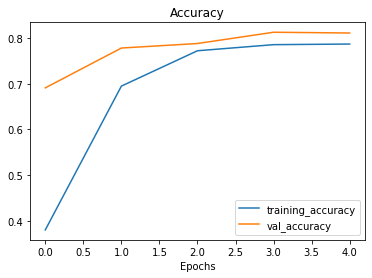

In [54]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpoint weights returns a model to a specific checkpoint.

In [55]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [56]:
checkpoint_path

'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

In [57]:
# Evaluate model_2 with loaded weigths
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.6894 - accuracy: 0.8200


In [58]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!

results_10_percent_data_aug == loaded_weights_model_results

True

## Model 3 : Fine-tuning an exisiting model on 10% of the data

> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [59]:
# Layers in loaded model
model_2.layers

In [60]:
# Are these layers trainalbe?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f8e55ee7290> True
<keras.engine.sequential.Sequential object at 0x7f8e55ee2d50> True
<keras.engine.functional.Functional object at 0x7f8e55b73bd0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8e55ec8d50> True
<keras.layers.core.dense.Dense object at 0x7f8ede106f10> True


In [61]:
# What layers are in our base model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [62]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [65]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr= 0.0001), # when fine-tuning we want lower the learning rate by 10x
                metrics = ["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


> **Note:** when using fine-tuning it's best practice to lower learning rate by some amount. How much?  This is a hyyperparmeter we can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).

The good sources is on the UMLFIt Paper : https://arxiv.org/abs/1801.06146

In [66]:
# Check  which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [67]:
print(len(model_2.trainable_variables))

12


In [68]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainalbe layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],# start training from the last epoch
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tune_last_10")]) 

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220219-094025
Epoch 5/10
24/24 [==============================] - 19s 438ms/step - loss: 0.6798 - accuracy: 0.8173 - val_loss: 0.6391 - val_accuracy: 0.7944
Epoch 6/10
24/24 [==============================] - 10s 395ms/step - loss: 0.5573 - accuracy: 0.8333 - val_loss: 0.5531 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 9s 335ms/step - loss: 0.4885 - accuracy: 0.8493 - val_loss: 0.5464 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 8s 302ms/step - loss: 0.4590 - accuracy: 0.8547 - val_loss: 0.5612 - val_accuracy: 0.8059
Epoch 9/10
24/24 [==============================] - 10s 383ms/step - loss: 0.4207 - accuracy: 0.8667 - val_loss: 0.5299 - val_accuracy: 0.8372
Epoch 10/10
24/24 [==============================] - 8s 339ms/step - loss: 0.3661 - accuracy: 0.8867 - val_loss: 0.5343 - val_accuracy: 0.8174


In [69]:
# Evaluate the fine-tuned model (model_3  which is actually model_2 fine-tune for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.5055 - accuracy: 0.8308


In [70]:
results_10_percent_data_aug

[0.6894330978393555, 0.8199999928474426]

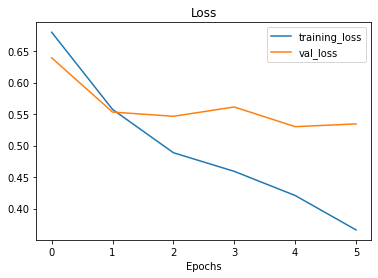

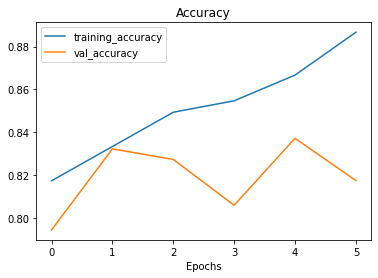

In [72]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [86]:
# Let's create a function to compare training histories

def  compare_histories(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label = "Training Accuray")
  plt.plot(total_val_acc, label ="Val Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label ="Val Loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label = "Start Fine Tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Accuracy")

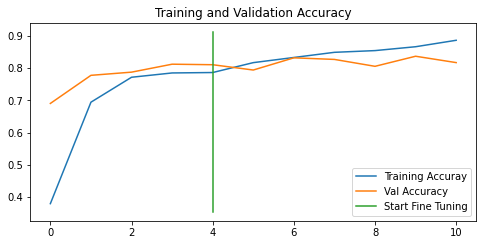

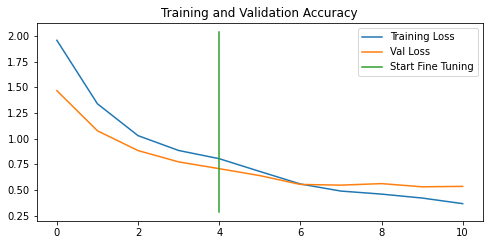

In [87]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs =5)

## Model 4: Fine-tuning and existing model on all of the data

In [88]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-02-19 09:58:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.240, 172.253.115.128, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   104MB/s    in 4.9s    

2022-02-19 09:58:05 (101 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [89]:
# Setup training and test dir

train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [90]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [93]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224,)
train_data_10_classes = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).
Let's verify this...


In [94]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.5055 - accuracy: 0.8308


[0.50550377368927, 0.8307999968528748]

In [95]:
results_fine_tune_10_percent

[0.5055035948753357, 0.8307999968528748]

To train a fine-tuningmodel (model_4) we need to revert model_2 back to its feature extraction weights.

In [96]:
# Load model from checkpoint, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from

model_2.load_weights(checkpoint_path)

In [97]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.6894 - accuracy: 0.8200


[0.6894330978393555, 0.8199999928474426]

In [98]:
# Check to see if our model_2 has been reverted back to feature extraction results

results_10_percent_data_aug

[0.6894330978393555, 0.8199999928474426]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.

2. Fine-tuined the same model on the same 10% of the data for a further 5 epcohs with the top 10 layers of the base model unfrozen (model_3).

3. Saved the results and training logs each time.

4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [100]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [102]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainalbe
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [103]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr= 0.0001),
                metrics = ["accuracy"])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [105]:
# Fit
fine_tune_epochs = initial_epochs +5

history_fine_10_classes_full = model_2.fit(train_data_10_classes,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = len(test_data),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                    experiment_name = "full_10_classesfine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classesfine_tune_last_10/20220219-102217
Epoch 5/10
235/235 [==============================] - 63s 237ms/step - loss: 0.7329 - accuracy: 0.7603 - val_loss: 0.4054 - val_accuracy: 0.8704
Epoch 6/10
235/235 [==============================] - 56s 236ms/step - loss: 0.5971 - accuracy: 0.8064 - val_loss: 0.3647 - val_accuracy: 0.8800
Epoch 7/10
235/235 [==============================] - 51s 216ms/step - loss: 0.5284 - accuracy: 0.8292 - val_loss: 0.3642 - val_accuracy: 0.8820
Epoch 8/10
235/235 [==============================] - 50s 208ms/step - loss: 0.4816 - accuracy: 0.8487 - val_loss: 0.3309 - val_accuracy: 0.8912
Epoch 9/10
235/235 [==============================] - 42s 178ms/step - loss: 0.4369 - accuracy: 0.8541 - val_loss: 0.3211 - val_accuracy: 0.8956
Epoch 10/10
235/235 [==============================] - 43s 181ms/step - loss: 0.4219 - accuracy: 0.8631 - val_loss: 0.3038 - val_accuracy: 0.9020


In [106]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 74ms/step - loss: 0.3038 - accuracy: 0.9020


[0.30376288294792175, 0.9020000100135803]

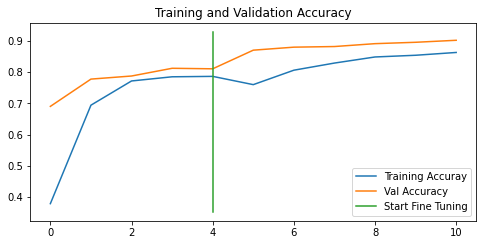

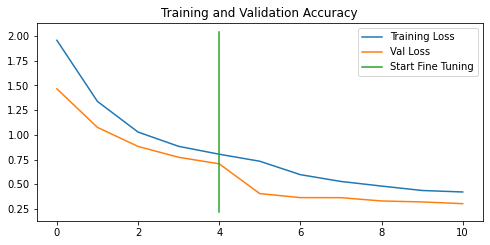

In [107]:
# How did fine-tuning go with more data?
compare_histories(original_history=history_10_percent_data_aug,
                  new_history = history_fine_10_classes_full,
                  initial_epochs = 5)

## Viewing our experiment data on TensorBoard

> **Note:** Anything we upload to TensorBoard.dev is going to be pubilic. So if we have private data, do not upload.

In [109]:
# View tensorboard logs of transfer learning modeling experiments (should be 4 models)
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes"\
  --description "A series of different transfer learning experiments with varying amount of data and fine tuning"\
  --one_shot # exits the uploader once its finished uploaded


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=MKiTmyz5neRYQTozutIJehxsmXyQIz&prompt=consent&access_type=o

My TensorBoard is availabe at : https://tensorboard.dev/experiment/FbSEJ4udSze7w7DMLBVbcQ/

In [110]:
!tensorboard dev list

https://tensorboard.dev/experiment/FbSEJ4udSze7w7DMLBVbcQ/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amount of data and fine tuning
	Id                   FbSEJ4udSze7w7DMLBVbcQ
	Created              2022-02-19 10:32:57 (2 minutes ago)
	Updated              2022-02-19 10:33:07 (2 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4308317
https://tensorboard.dev/experiment/mhEdvYGLRKK5qz5xTlQEXA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the trainig data
	Id                   mhEdvYGLRKK5qz5xTlQEXA
	Created              2022-02-14 09:46:29
	Updated              2022-02-14 09:46:31
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0

In [ ]:
# To delete an experiment
# !tensorboard dev delete --experiment_id FbSEJ4udSze7w7DMLBVbcQ